In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras import backend as K
K.set_image_dim_ordering('tf')
from time import time
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_data():
    print('loading data...')
    start = time()
    X = np.loadtxt('rgbframes.csv',delimiter=',',dtype=np.float32)
    X.shape=(-1,180,320,3)
    print('Job completed in {} seconds'.format(time()-start))
    return X
X = load_data()

print(X.shape)

loading data...
Job completed in 1045.3980708122253 seconds


NameError: name 'start' is not defined

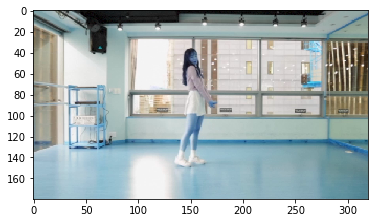

In [3]:
data = X
np.random.shuffle(data)
data = data / 255
n = 1650
train = data[:n]
test = data[n:]
plt.imshow(test[0])

In [4]:
input_img = Input(shape=(180,320,3))

e1 = Conv2D(16,(15,15),activation='relu',padding='same')(input_img) #166 306 16
e2 = MaxPooling2D((2,2), padding='same')(e1) #83 153 16
e3 = Conv2D(8,(5,5),activation='relu',padding='same')(e2) #79 149 8
e4 = MaxPooling2D((2,2),padding='same')(e3) #40 75 8

d2 = UpSampling2D((2,2))(e4)
d3 = Conv2D(8,(5,5),activation='relu',padding='same')(d2)
d4 = UpSampling2D((2,2))(d3)
decoded = Conv2D(3,(15,15),activation='sigmoid',padding='same')(d4)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta',loss='binary_crossentropy')

encoder = Model(input_img, e4)
encoded_input = Input(shape=(45,80,8))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))


In [6]:
autoencoder.fit(train,train, epochs=20, batch_size=32, 
                validation_data=(test,test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 1650 samples, validate on 382 samples
Epoch 1/20
1650/1650 [==============================] - 820s - loss: 0.6655 - val_loss: 0.6863
Epoch 2/20
1650/1650 [==============================] - 847s - loss: 0.6458 - val_loss: 0.6240
Epoch 3/20
1650/1650 [==============================] - 815s - loss: 0.6253 - val_loss: 0.6160
Epoch 4/20
1650/1650 [==============================] - 825s - loss: 0.6148 - val_loss: 0.6153
Epoch 5/20
1650/1650 [==============================] - 834s - loss: 0.6050 - val_loss: 0.5944
Epoch 6/20
1650/1650 [==============================] - 846s - loss: 0.5984 - val_loss: 0.6034
Epoch 7/20
1650/1650 [==============================] - 854s - loss: 0.5930 - val_loss: 0.6031
Epoch 8/20
1650/1650 [==============================] - 863s - loss: 0.5905 - val_loss: 0.5954
Epoch 9/20
1650/1650 [==============================] - 862s - loss: 0.5890 - val_loss: 0.5886
Epoch 10/20
1650/1650 [==============================] - 862s - loss: 0.5879 - val_loss: 0.5859
Ep

In [7]:
encoded_imgs = encoder.predict(test)
decoded_imgs = decoder.predict(encoded_imgs)
decodedae = autoencoder.predict(test)

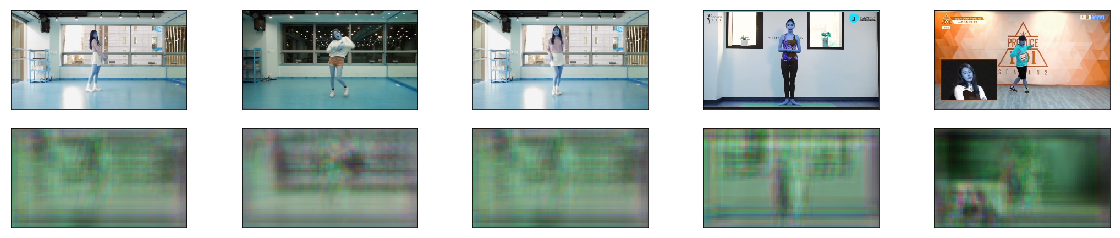

In [8]:
n=5
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    img = test[i*4]
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+1+n)
    newimg = decoded_imgs[i*4]
    plt.imshow(newimg)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

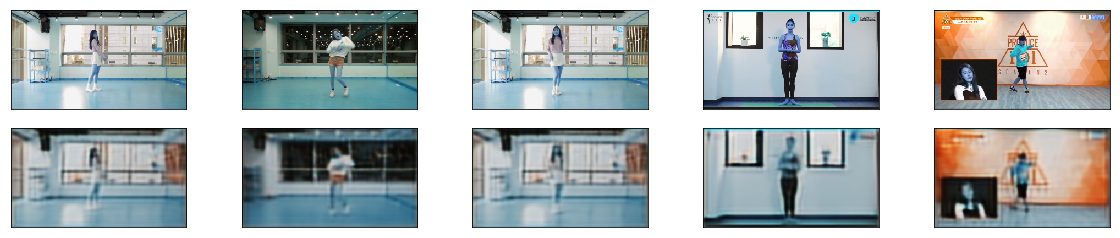

In [13]:
n=5
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    img = test[i*4]
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+1+n)
    newimg = decodedae[i*4]
    plt.imshow(newimg)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
print(encoded_imgs.shape)
encoded_input = Input(shape=(45,80,8))
decoder = Model(encoded_input, decoder_layer(encoded_input))

(382, 45, 80, 8)


In [10]:
encodedhere = encoded_imgs.reshape(-1, 45*80, 8)
print(encodedhere.shape)
newE = []
for i, img in enumerate(encodedhere):
    newE.append(encodedhere[i].T) #-1 8, 45*80

(382, 3600, 8)


In [11]:
newE = np.array(newE).reshape(-1,8,45,80)

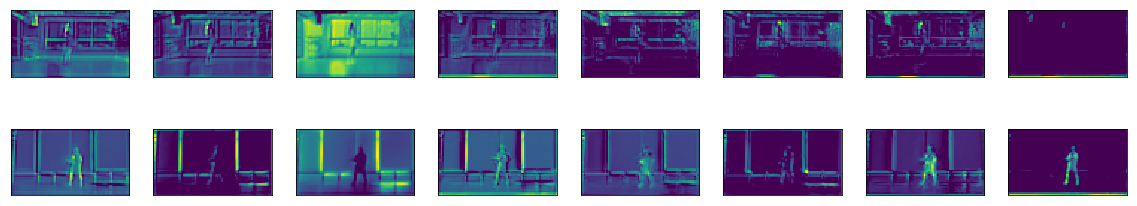

In [12]:
n=8
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    img = newE[0][i]
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+1+n)
    newimg = newE[1][i]
    plt.imshow(newimg)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
reps = encoder.predict(X)
print(reps.shape)

(2032, 45, 80, 8)


In [17]:
reps = reps.reshape(-1,45*80,8)
rf = open('rep36008.csv','w')
writer = csv.writer(rf, lineterminator = '\n')
writer.writerows(reps)
rf.close()